In [1]:
import glob
import random

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from icecream import ic
from mpl_toolkits.axes_grid1 import ImageGrid

import label_mapping
from ext.mindboggle.labels import extract_numbers_names_colors

In [2]:
KWYK_DATA = '/nese/mit/group/sig/data/kwyk/rawdata'
asegs = glob.glob(KWYK_DATA + '/*aseg*')

aseg_file = random.choice(asegs)
ic(aseg_file)
aseg = nib.load(aseg_file).get_fdata().astype(np.uint)
ic(aseg.shape)

ic| aseg_file: '/nese/mit/group/sig/data/kwyk/rawdata/pac_7161_aseg.nii.gz'
ic| aseg.shape: (256, 256, 256)


(256, 256, 256)

In [3]:
# plot before mapping
direction_map = {0: "sagittal", 1: "coronal", 2: "axial"}

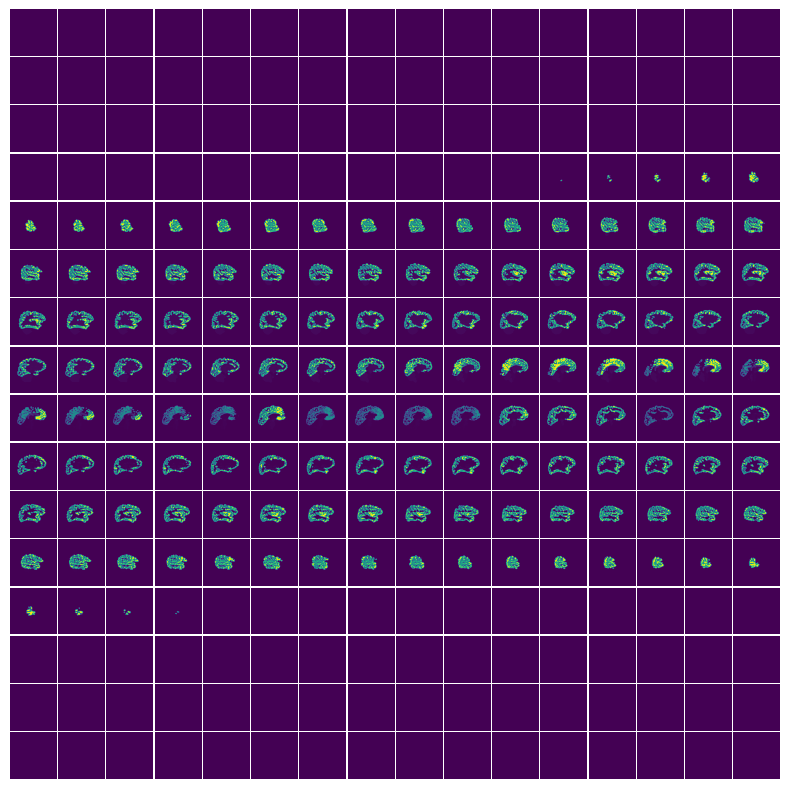

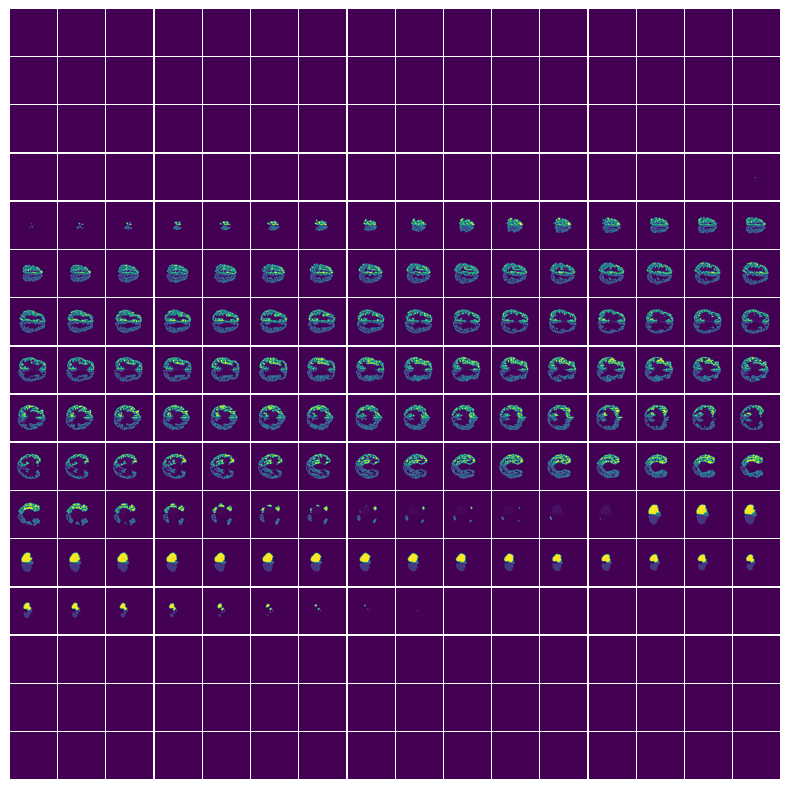

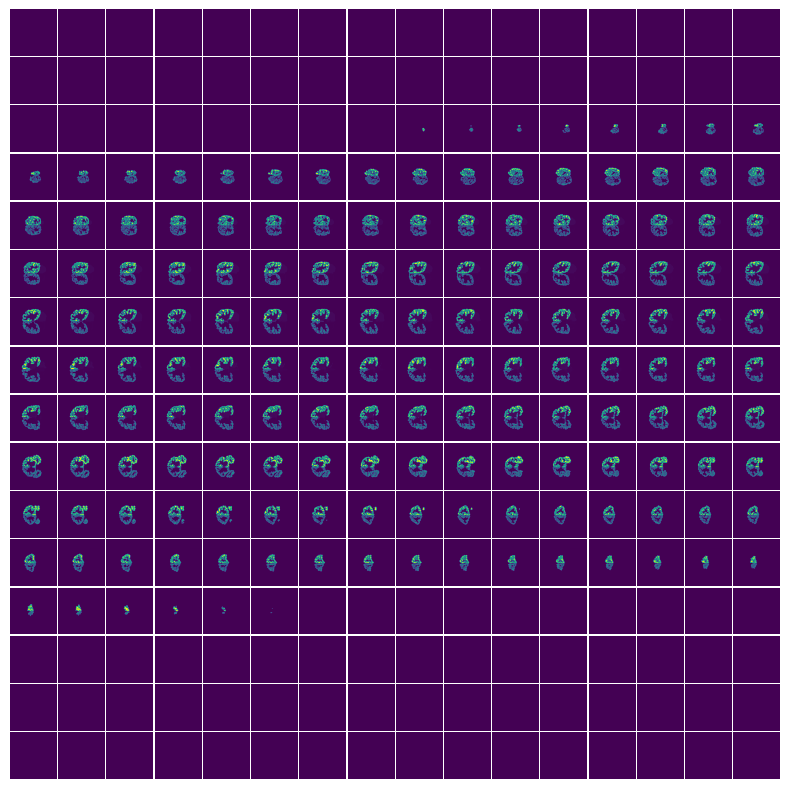

In [4]:
# Create a grid of subplots
for direction in direction_map:
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(16, 16),  # creates a 3x3 grid of axes
                    axes_pad=0.015,  # pad between axes in inches
                    )

    # Plot each brain slice
    for ax, brain_slice in zip(grid, np.moveaxis(aseg, direction, 0)):
        ax.imshow(brain_slice)
        ax.axis('off')

    # plt.suptitle('Brain Slices')
    # plt.savefig(f'{direction}.png', dpi=600)
    # plt.savefig('page1.pdf', dpi=600)
    plt.show()

In [5]:
n_classes = 50  # 6 or 50 or 115
label_map = label_mapping.get_label_mapping(n_classes)

Using label mapping file: /om2/user/hgazula/nobrainer_training_scripts/csv-files/50-class-mapping.csv
Conversion into 50 segmentation classes from freesurfer labels


In [6]:
u, inv = np.unique(aseg, return_inverse=True)
aseg_new = np.array([label_map.get(x, 0) for x in u])[inv]

ic(len(np.unique(aseg_new)))
print()

ic| len(np.unique(aseg_new)): 50


In [7]:
fs_number, fs_names, fs_colors = extract_numbers_names_colors(
    "/om2/user/hgazula/freesurfer/FreeSurferColorLUT.txt"
)

if n_classes == 115:
    df = pd.read_csv("/om2/user/hgazula/nobrainer_training_scripts/csv-files/115-class-mapping.csv", 
                 header='infer')       
else:
    df = pd.read_csv("/om2/user/hgazula/nobrainer_training_scripts/csv-files/50-class-mapping.csv",
                     header='infer',
                 index_col=0)
    
df["colors"] = df["original"].apply(lambda x: fs_colors[fs_number.index(x)])
df = df.drop_duplicates(subset='new')

my_colors = df.colors.tolist()
my_colors[0] = [255, 255, 255]  # replacing background with white color
cmap = mcolors.ListedColormap(np.array(my_colors) / 255)

# assert len(np.unique(aseg_new)) == len(my_colors), "invalid number of classes"

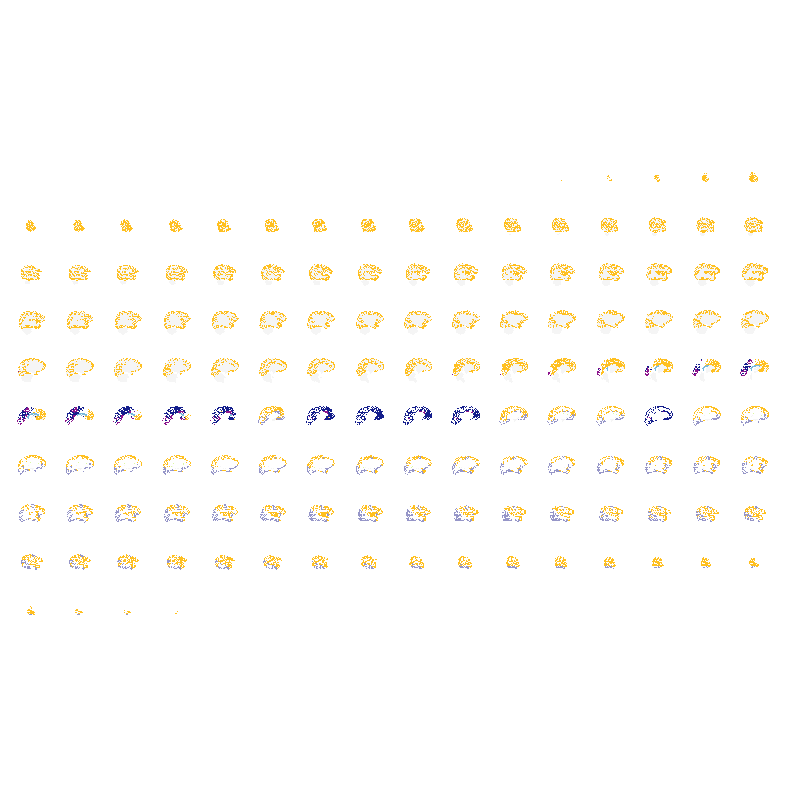

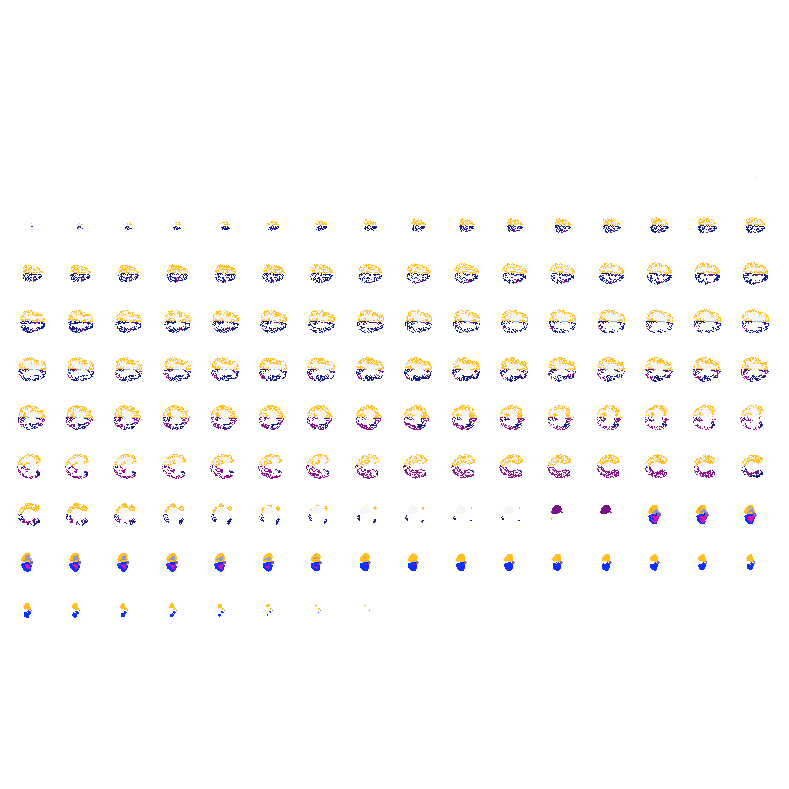

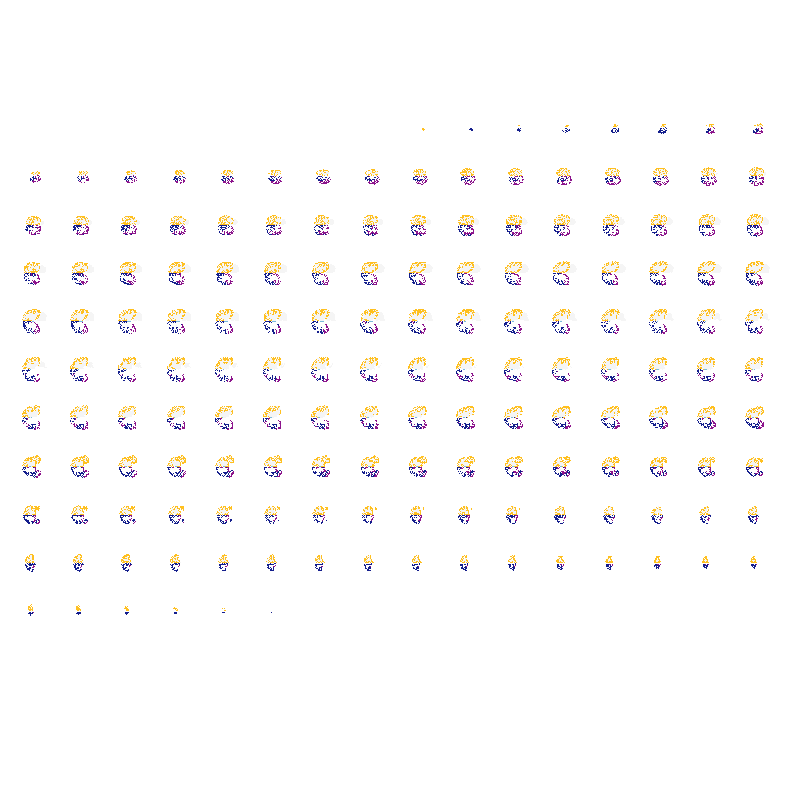

In [8]:
for axis, direction in direction_map.items():
    # Create a grid of subplots
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(16, 16),  # creates a 3x3 grid of axes
                    axes_pad=0.015,  # pad between axes in inches
                    )

    # Plot each brain slice
    for ax, brain_slice in zip(grid, np.moveaxis(aseg, axis, 0)):
        ax.imshow(brain_slice, cmap=cmap, interpolation="nearest")
        ax.axis('off')

    # plt.suptitle('Brain Slices')
    plt.savefig(f'{direction}.png', dpi=600)  # Use higher dpi for better resolution
    # plt.savefig('page1.pdf', dpi=600)
    plt.show()